# U-Net (modified)



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras

### Data input pipeline

In [0]:
# loading in the cleaned and normalized data
train_data_og = np.load("../../gcp/train-processed/train_x_l2a_cleaned_norm.npy")
train_labels_og= np.load('../../gcp/train-processed/data_y_l2a_processed.npy')
train_length = np.load('../../gcp/train-processed/length_l2a_processed.npy')
test_data_og = np.load("../../gcp/test-processed/test_x_l2a_cleaned_norm.npy")
test_labels_og = np.load('../../gcp/test-processed/test_y_l2a_processed.npy')
test_length = np.load('../../gcp/test-processed/test_length_l2a_processed.npy')

https://www.tensorflow.org/tutorials/load_data/numpy


In [0]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
TRAIN_LENGTH = len(train_length)

In [0]:
# selecting a single time-slice of the data
train_data = train_data_og[:,18,:,:,:]
test_data = test_data_og[:,18,:,:,:]

# create a Dataset using the tf.data API
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels_og))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels_og))

# creating the random batches
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)


In [0]:
train_dataset

<BatchDataset shapes: ((None, 16, 16, 16), (None, 14, 14)), types: (tf.float32, tf.float64)>

**BUFFER_SIZE:**
This dataset fills a buffer with buffer_size elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.

For instance, if your dataset contains 10,000 elements but buffer_size is set to 1,000, then shuffle will initially select a random element from only the first 1,000 elements in the buffer. Once an element is selected, its space in the buffer is replaced by the next (i.e. 1,001-st) element, maintaining the 1,000 element buffer.
https://www.tensorflow.org/api_docs/python/tf/data/Dataset

## Building the U-Net

In [0]:
# setting the number of output classes
# ? I could try with 1 and then classify by ><0.5 -> will try later
OUTPUT_CHANNELS = 2

below from: https://www.tensorflow.org/tutorials/generative/pix2pix

In [0]:
def downsample(filters, size, stride=2, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=stride, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [0]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [0]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[16, 16, 16])

  down_stack = [
    downsample(64, 4, 1, apply_batchnorm=False), # (bs, 16,16, 64)
    downsample(128, 4, apply_batchnorm=False), # (bs, 8, 8, 128)
    downsample(256, 4), # (bs, 4, 4, 256)
  ]

  up_stack = [
    upsample(128, 4, apply_dropout=False), # (bs, 8, 8, 256)
    upsample(64, 4, apply_dropout=False), # (bs, 16, 16, 128)
  ]


  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)
    
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2D(output_channels, 3, strides=1, padding='valid')  #8x8 -> 14x14

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
unet = unet_model(2)

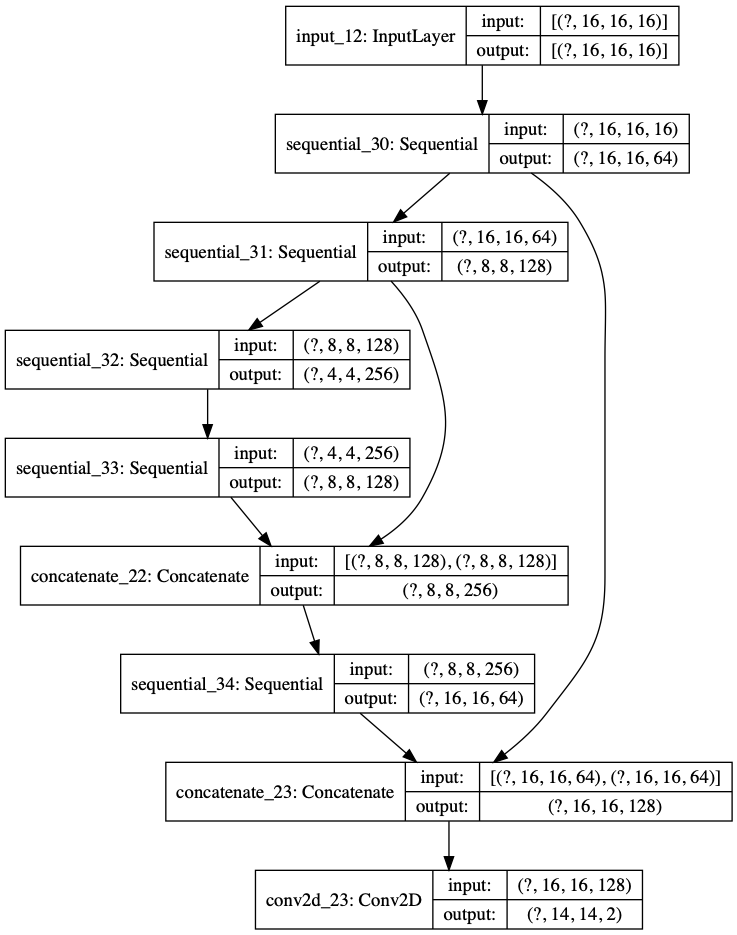

In [0]:
tf.keras.utils.plot_model(unet, show_shapes=True)

In [0]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', ])

In [0]:
EPOCHS = 300
VAL_SUBSPLITS = 5
VALIDATION_STEPS = len(test_length)//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)

Train for 137 steps, validate for 4 steps
Epoch 1/300
137/137 [==============================] - 17s 126ms/step - loss: 0.4470 - accuracy: 0.8090 - val_loss: 0.4699 - val_accuracy: 0.7514
Epoch 2/300
137/137 [==============================] - 16s 120ms/step - loss: 0.4468 - accuracy: 0.8052 - val_loss: 0.6900 - val_accuracy: 0.6056
Epoch 3/300
137/137 [==============================] - 16s 116ms/step - loss: 0.4493 - accuracy: 0.8060 - val_loss: 0.8598 - val_accuracy: 0.5635
Epoch 4/300
137/137 [==============================] - 16s 114ms/step - loss: 0.4434 - accuracy: 0.8079 - val_loss: 0.9856 - val_accuracy: 0.4886
Epoch 5/300
137/137 [==============================] - 16s 115ms/step - loss: 0.4449 - accuracy: 0.8108 - val_loss: 0.8051 - val_accuracy: 0.5711
Epoch 6/300
137/137 [==============================] - 16s 115ms/step - loss: 0.4419 - accuracy: 0.8085 - val_loss: 0.6651 - val_accuracy: 0.6305
Epoch 7/300
137/137 [==============================] - 16s 116ms/step - loss: 0.43

137/137 [==============================] - 16s 114ms/step - loss: 0.4051 - accuracy: 0.8255 - val_loss: 1.6273 - val_accuracy: 0.4749
Epoch 57/300
137/137 [==============================] - 16s 114ms/step - loss: 0.4011 - accuracy: 0.8271 - val_loss: 1.2659 - val_accuracy: 0.5064
Epoch 58/300
137/137 [==============================] - 16s 114ms/step - loss: 0.3965 - accuracy: 0.8305 - val_loss: 1.8539 - val_accuracy: 0.4165
Epoch 59/300
137/137 [==============================] - 16s 114ms/step - loss: 0.3944 - accuracy: 0.8315 - val_loss: 1.7858 - val_accuracy: 0.4650
Epoch 60/300
137/137 [==============================] - 16s 114ms/step - loss: 0.3940 - accuracy: 0.8320 - val_loss: 1.6105 - val_accuracy: 0.4200
Epoch 61/300
137/137 [==============================] - 16s 115ms/step - loss: 0.3951 - accuracy: 0.8318 - val_loss: 1.7747 - val_accuracy: 0.3705
Epoch 62/300
137/137 [==============================] - 16s 115ms/step - loss: 0.3966 - accuracy: 0.8314 - val_loss: 1.8340 - val_a

Epoch 112/300
137/137 [==============================] - 15s 111ms/step - loss: 0.3491 - accuracy: 0.8545 - val_loss: 2.4909 - val_accuracy: 0.3916
Epoch 113/300
137/137 [==============================] - 15s 112ms/step - loss: 0.3500 - accuracy: 0.8525 - val_loss: 1.7791 - val_accuracy: 0.4546
Epoch 114/300
137/137 [==============================] - 15s 112ms/step - loss: 0.3496 - accuracy: 0.8534 - val_loss: 1.4518 - val_accuracy: 0.5299
Epoch 115/300
137/137 [==============================] - 15s 111ms/step - loss: 0.3520 - accuracy: 0.8517 - val_loss: 1.3466 - val_accuracy: 0.5091
Epoch 116/300
137/137 [==============================] - 15s 111ms/step - loss: 0.3518 - accuracy: 0.8528 - val_loss: 0.8743 - val_accuracy: 0.5893
Epoch 117/300
137/137 [==============================] - 15s 110ms/step - loss: 0.3519 - accuracy: 0.8518 - val_loss: 0.9872 - val_accuracy: 0.6259
Epoch 118/300
137/137 [==============================] - 15s 111ms/step - loss: 0.3456 - accuracy: 0.8545 - val_

137/137 [==============================] - 15s 112ms/step - loss: 0.2746 - accuracy: 0.8899 - val_loss: 0.5433 - val_accuracy: 0.7646
Epoch 168/300
137/137 [==============================] - 15s 112ms/step - loss: 0.2643 - accuracy: 0.8953 - val_loss: 0.5872 - val_accuracy: 0.7364
Epoch 169/300
137/137 [==============================] - 15s 112ms/step - loss: 0.2681 - accuracy: 0.8930 - val_loss: 0.9620 - val_accuracy: 0.6358
Epoch 170/300
137/137 [==============================] - 16s 114ms/step - loss: 0.2730 - accuracy: 0.8904 - val_loss: 0.7589 - val_accuracy: 0.6728
Epoch 171/300
137/137 [==============================] - 15s 112ms/step - loss: 0.2694 - accuracy: 0.8924 - val_loss: 0.5618 - val_accuracy: 0.7517
Epoch 172/300
137/137 [==============================] - 15s 112ms/step - loss: 0.2719 - accuracy: 0.8915 - val_loss: 0.5900 - val_accuracy: 0.7412
Epoch 173/300
137/137 [==============================] - 15s 112ms/step - loss: 0.2700 - accuracy: 0.8917 - val_loss: 0.5663 -

137/137 [==============================] - 15s 111ms/step - loss: 0.1916 - accuracy: 0.9259 - val_loss: 0.8212 - val_accuracy: 0.7217
Epoch 223/300
137/137 [==============================] - 15s 112ms/step - loss: 0.1912 - accuracy: 0.9256 - val_loss: 0.8819 - val_accuracy: 0.7148
Epoch 224/300
137/137 [==============================] - 15s 111ms/step - loss: 0.1871 - accuracy: 0.9276 - val_loss: 0.8911 - val_accuracy: 0.7138
Epoch 225/300
137/137 [==============================] - 15s 112ms/step - loss: 0.1813 - accuracy: 0.9297 - val_loss: 0.9076 - val_accuracy: 0.7075
Epoch 226/300
137/137 [==============================] - 15s 111ms/step - loss: 0.1816 - accuracy: 0.9297 - val_loss: 0.8607 - val_accuracy: 0.7210
Epoch 227/300
137/137 [==============================] - 15s 111ms/step - loss: 0.1861 - accuracy: 0.9281 - val_loss: 0.7651 - val_accuracy: 0.7504
Epoch 228/300
137/137 [==============================] - 15s 111ms/step - loss: 0.1791 - accuracy: 0.9306 - val_loss: 0.7574 -

137/137 [==============================] - 15s 111ms/step - loss: 0.1273 - accuracy: 0.9503 - val_loss: 0.8462 - val_accuracy: 0.7602
Epoch 278/300
137/137 [==============================] - 15s 112ms/step - loss: 0.1221 - accuracy: 0.9522 - val_loss: 0.9351 - val_accuracy: 0.7382
Epoch 279/300
137/137 [==============================] - 15s 111ms/step - loss: 0.1234 - accuracy: 0.9518 - val_loss: 0.7983 - val_accuracy: 0.7579
Epoch 280/300
137/137 [==============================] - 15s 112ms/step - loss: 0.1306 - accuracy: 0.9487 - val_loss: 0.8439 - val_accuracy: 0.7499
Epoch 281/300
137/137 [==============================] - 15s 112ms/step - loss: 0.1262 - accuracy: 0.9507 - val_loss: 1.0490 - val_accuracy: 0.7177
Epoch 282/300
137/137 [==============================] - 15s 112ms/step - loss: 0.1238 - accuracy: 0.9518 - val_loss: 0.9083 - val_accuracy: 0.7345
Epoch 283/300
137/137 [==============================] - 15s 111ms/step - loss: 0.1212 - accuracy: 0.9527 - val_loss: 0.9010 -

In [0]:
len(test_length)//BATCH_SIZE

21

**validation_steps:** Only relevant if validation_data is provided and is a tf.data dataset. Total number of steps (batches of samples) to draw before stopping when performing validation at the end of every epoch. If 'validation_steps' is None, validation will run until the validation_data dataset is exhausted. In the case of a infinite dataset, it will run into a infinite loop. If 'validation_steps' is specified and only part of the dataset will be consumed, the evaluation will start from the beginning of the dataset at each epoch. This ensures that the same validation samples are used every time.

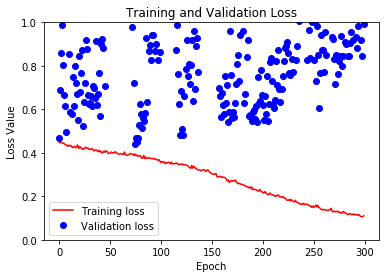

In [0]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [0]:
dict.keys(model_history.history)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

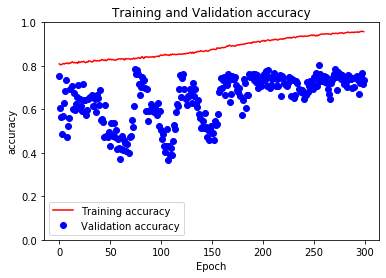

In [0]:
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'bo', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()

Tomorrow:
- Check out Adam optimizer

### Saving the model 
including architecture and weights so training can continue from here and you can load it in

In [0]:
model.save('u_net_v1')

INFO:tensorflow:Assets written to: u_net_v1/assets


INFO:tensorflow:Assets written to: u_net_v1/assets


In [0]:
model.save('u_net_v1.h5')

In [0]:
model2 = keras.models.load_model('u_net_v1.h5')

In [0]:
model2

In [0]:

EPOCHS2 = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = len(test_length)//BATCH_SIZE//VAL_SUBSPLITS

model2.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model2_history = model2.fit(train_dataset, epochs=EPOCHS2,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)

Train for 137 steps, validate for 4 steps
Epoch 1/20
137/137 [==============================] - 17s 123ms/step - loss: 0.1716 - accuracy: 0.9349 - val_loss: 0.7868 - val_accuracy: 0.7841
Epoch 2/20
137/137 [==============================] - 16s 118ms/step - loss: 0.1663 - accuracy: 0.9351 - val_loss: 0.7558 - val_accuracy: 0.7885
Epoch 3/20
137/137 [==============================] - 16s 120ms/step - loss: 0.1588 - accuracy: 0.9377 - val_loss: 0.7263 - val_accuracy: 0.7894
Epoch 4/20
137/137 [==============================] - 16s 120ms/step - loss: 0.1539 - accuracy: 0.9395 - val_loss: 0.7033 - val_accuracy: 0.7990
Epoch 5/20
137/137 [==============================] - 18s 129ms/step - loss: 0.1510 - accuracy: 0.9407 - val_loss: 0.6938 - val_accuracy: 0.7989
Epoch 6/20
137/137 [==============================] - 18s 134ms/step - loss: 0.1485 - accuracy: 0.9415 - val_loss: 0.6726 - val_accuracy: 0.8055
Epoch 7/20
137/137 [==============================] - 17s 123ms/step - loss: 0.1443 - ac

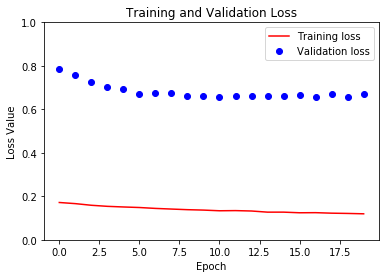

In [0]:
loss2 = model2_history.history['loss']
val_loss2 = model2_history.history['val_loss']

epochs = range(EPOCHS2)

plt.figure()
plt.plot(epochs, loss2, 'r', label='Training loss')
plt.plot(epochs, val_loss2, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

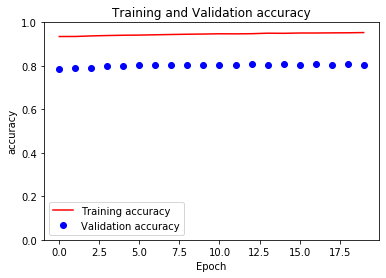

In [0]:
accuracy2 = model2_history.history['accuracy']
val_accuracy2 = model2_history.history['val_accuracy']

epochs = range(EPOCHS2)

plt.figure()
plt.plot(epochs, accuracy2, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy2, 'bo', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [0]:

EPOCHS2 = 20
VAL_SUBSPLITS = 1
VALIDATION_STEPS = len(test_length)//BATCH_SIZE//VAL_SUBSPLITS

model2.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model2_history = model2.fit(train_dataset, epochs=EPOCHS2,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)

Train for 137 steps, validate for 21 steps
Epoch 1/20
137/137 [==============================] - 15s 109ms/step - loss: 0.1226 - accuracy: 0.9516 - val_loss: 0.7634 - val_accuracy: 0.8020
Epoch 2/20
137/137 [==============================] - 17s 128ms/step - loss: 0.1124 - accuracy: 0.9553 - val_loss: 0.7569 - val_accuracy: 0.8049
Epoch 3/20
137/137 [==============================] - 17s 127ms/step - loss: 0.1106 - accuracy: 0.9563 - val_loss: 0.7542 - val_accuracy: 0.8048
Epoch 4/20
137/137 [==============================] - 18s 129ms/step - loss: 0.1095 - accuracy: 0.9565 - val_loss: 0.7548 - val_accuracy: 0.8049
Epoch 5/20
137/137 [==============================] - 17s 122ms/step - loss: 0.1096 - accuracy: 0.9566 - val_loss: 0.7531 - val_accuracy: 0.8046
Epoch 6/20
137/137 [==============================] - 17s 121ms/step - loss: 0.1073 - accuracy: 0.9576 - val_loss: 0.7541 - val_accuracy: 0.8045
Epoch 7/20
137/137 [==============================] - 17s 125ms/step - loss: 0.1072 - a

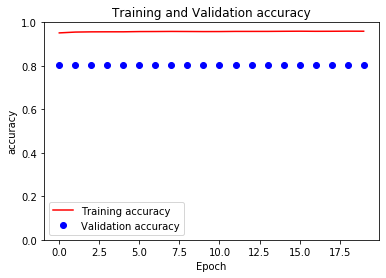

In [0]:
accuracy2 = model2_history.history['accuracy']
val_accuracy2 = model2_history.history['val_accuracy']

epochs = range(EPOCHS2)

plt.figure()
plt.plot(epochs, accuracy2, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy2, 'bo', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [0]:
model2.save('u_net_v2')
model2.save('u_net_v2.h5')


INFO:tensorflow:Assets written to: u_net_v2/assets


INFO:tensorflow:Assets written to: u_net_v2/assets


## Plotting some examples
### Train data

In [0]:
import matplotlib.gridspec as gridspec

In [0]:
def create_mask(pred_mask, n):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  return pred_mask[n]

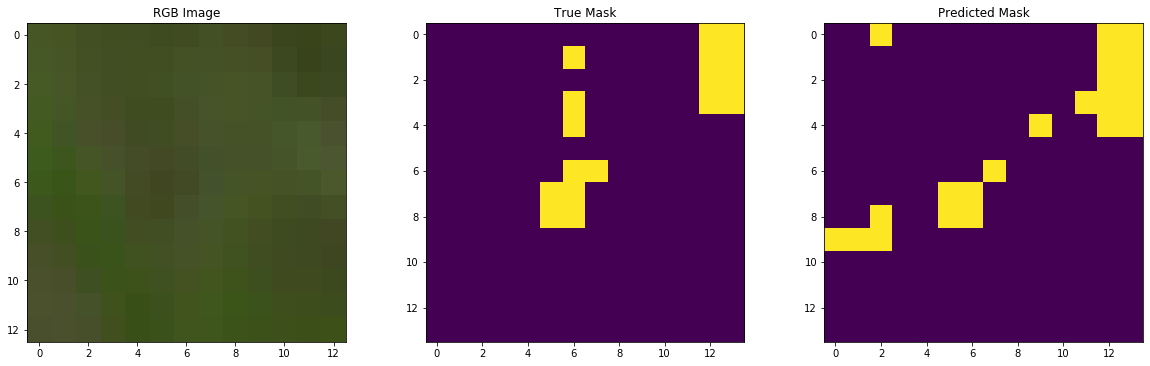

In [0]:
n = 4

plt.figure(figsize=(20,20))
gs1 = gridspec.GridSpec(1, 3)
gs1.update(wspace=0.25, hspace=0.05) # set the spacing between axes. 

for image, mask in train_dataset.take(1):
    plt.subplot(gs1[0])
    plt.imshow(np.asarray(image[n,2:15,2:15,2:5])[:,:,::-1])
    plt.title('RGB Image')
    plt.subplot(gs1[1])
    plt.imshow(mask[n,:,:])
    plt.title('True Mask')
    plt.subplot(gs1[2])
    plt.imshow(create_mask(model.predict(image[:,:,:,:]), n))
    plt.title('Predicted Mask')


### Test data

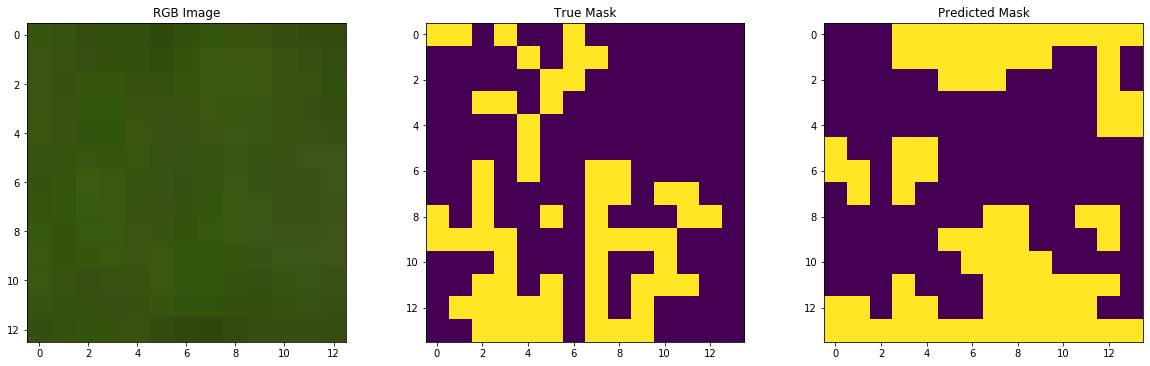

In [0]:
n = 10

plt.figure(figsize=(20,20))
gs1 = gridspec.GridSpec(1, 3)
gs1.update(wspace=0.25, hspace=0.05) # set the spacing between axes. 

for image, mask in test_dataset.take(1):
    plt.subplot(gs1[0])
    plt.imshow(np.asarray(image[n,2:15,2:15,2:5])[:,:,::-1])
    plt.title('RGB Image')
    plt.subplot(gs1[1])
    plt.imshow(mask[n,:,:])
    plt.title('True Mask')
    plt.subplot(gs1[2])
    plt.imshow(create_mask(model.predict(image[:,:,:,:]), n))
    plt.title('Predicted Mask')



In [0]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      plt.imshow([image[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

## Model 2

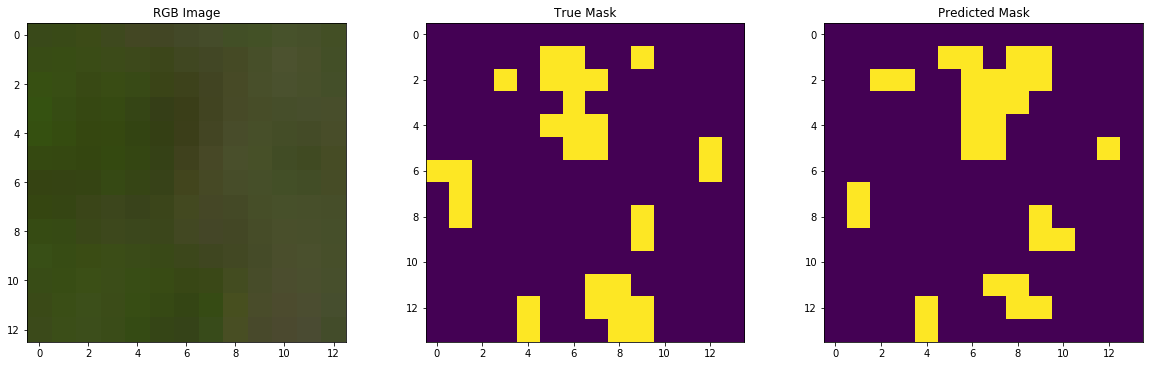

In [0]:
n = 3

plt.figure(figsize=(20,20))
gs1 = gridspec.GridSpec(1, 3)
gs1.update(wspace=0.25, hspace=0.05) # set the spacing between axes. 

for image, mask in train_dataset.take(1):
    plt.subplot(gs1[0])
    plt.imshow(np.asarray(image[n,2:15,2:15,2:5])[:,:,::-1])
    plt.title('RGB Image')
    plt.subplot(gs1[1])
    plt.imshow(mask[n,:,:])
    plt.title('True Mask')
    plt.subplot(gs1[2])
    plt.imshow(create_mask(model2.predict(image[:,:,:,:]), n))
    plt.title('Predicted Mask')

Next I could try something like:


# -----------------------------------------------------------------

In [0]:
import tensorflow as tf

In [0]:
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [0]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [0]:
dataset

{'test': <DatasetV1Adapter shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>,
 'train': <DatasetV1Adapter shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>}

In [0]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [0]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [0]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [0]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [0]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [0]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [0]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [0]:
OUTPUT_CHANNELS = 3

In [0]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [0]:
base_model.input

<tf.Tensor 'input_1:0' shape=(None, 128, 128, 3) dtype=float32>

In [0]:
down_stack

In [0]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [0]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

 # ?
- why does the last layer have to be separate?
- how does Conv2DTranspose work?
    - what is the 3 in its arguments? why is stride =2

In [0]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

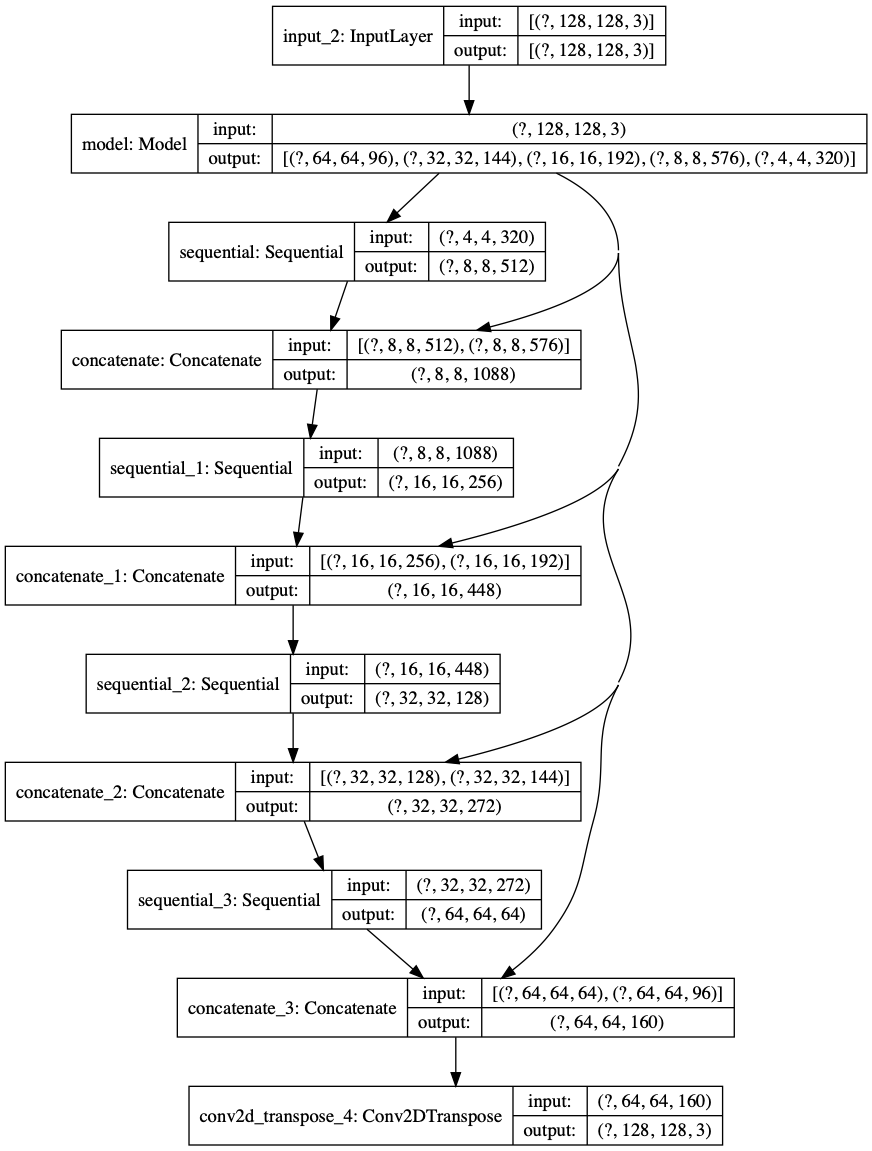

In [0]:
tf.keras.utils.plot_model(model, show_shapes=True)